In [57]:
%load_ext autoreload
%autoreload 2

import numpy as np
import nibabel as nb
import matplotlib.pyplot as pl
import os
opj = os.path.join
%matplotlib notebook
pl.ion()

import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
from prfpy.stimulus import PRFStimulus2D
from prfpy.grid import Iso2DGaussianGridder, Norm_Iso2DGaussianGridder
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter
from prfpy.timecourse import sgfilter_predictions
from utils.utils import *

In [4]:
#create stimulus
dm_1R = create_dm_from_screenshots(screenshot_path='/Users/marcoaqil/PRFMapping/PRFMapping-Raw/sub-001/ses-1/rawdata/sub-001_ses-1_Logs/sub-001_ses-1_task-1R_run-1_Logs/Screenshots')
dm_1S = create_dm_from_screenshots(screenshot_path='/Users/marcoaqil/PRFMapping/PRFMapping-Raw/sub-001/ses-1/rawdata/sub-001_ses-1_Logs/sub-001_ses-1_task-1S_run-1_Logs/Screenshots')
dm_2R = create_dm_from_screenshots(screenshot_path='/Users/marcoaqil/PRFMapping/PRFMapping-Raw/sub-001/ses-1/rawdata/sub-001_ses-1_Logs/sub-001_ses-1_task-2R_run-1_Logs/Screenshots')
dm_4F = create_dm_from_screenshots(screenshot_path='/Users/marcoaqil/PRFMapping/PRFMapping-Raw/sub-001/ses-1/rawdata/sub-001_ses-1_Logs/sub-001_ses-1_task-4F_run-1_Logs/Screenshots')
dm_4R = create_dm_from_screenshots(screenshot_path='/Users/marcoaqil/PRFMapping/PRFMapping-Raw/sub-001/ses-1/rawdata/sub-001_ses-1_Logs/sub-001_ses-1_task-4R_run-1_Logs/Screenshots')

discard_volumes = 5
dm_full = np.concatenate((dm_1R[:,:,discard_volumes:],
                          dm_1S[:,:,discard_volumes:],
                          dm_2R[:,:,discard_volumes:],
                          dm_4F[:,:,discard_volumes:],
                          dm_4R[:,:,discard_volumes:]), axis=-1)

prf_stim = PRFStimulus2D(screen_size_cm=70, 
                         screen_distance_cm=210, 
                         design_matrix=dm_full,
                         TR=1.5)

In [44]:
a = np.array([220,380,220,140,220])

140

In [32]:
iso_periods = np.where(np.sum(dm_full, axis=(0,1))==0)[0]
shifted_dm = np.zeros_like(dm_full)
#number of TRs in which activity may linger (hrf)
shifted_dm[:,:,7:] = dm_full[:,:,:-7]

late_iso_periods = np.where((np.sum(dm_full, axis=(0,1))==0) & (np.sum(shifted_dm, axis=(0,1))==0))[0]
print(late_iso_periods)
late_iso_dict={}
late_iso_dict['1R'] = np.split(late_iso_periods,5)[0]
late_iso_dict['1S'] = np.split(late_iso_periods,5)[1]
late_iso_dict['2R'] = np.split(late_iso_periods,5)[2]
late_iso_dict['4F'] = np.split(late_iso_periods,5)[3]
late_iso_dict['4R'] = np.split(late_iso_periods,5)[4]

[   0    1    2    3    4    5    6    7    8    9   57   58   59  107
  108  109  157  158  159  207  208  209  210  211  212  213  214  215
  216  217  218  219  220  221  222  223  224  225  226  227  228  229
  317  318  319  407  408  409  497  498  499  587  588  589  590  591
  592  593  594  595  596  597  598  599  600  601  602  603  604  605
  606  607  608  609  657  658  659  707  708  709  757  758  759  807
  808  809  810  811  812  813  814  815  816  817  818  819  820  821
  822  823  824  825  826  827  828  829  857  858  859  887  888  889
  917  918  919  947  948  949  950  951  952  953  954  955  956  957
  958  959  960  961  962  963  964  965  966  967  968  969 1017 1018
 1019 1067 1068 1069 1117 1118 1119 1167 1168 1169 1170 1171 1172 1173
 1174 1175 1176 1177 1178 1179]


In [26]:
data_path = '/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-noflairtse-manual-hires'
subj = 'sub-001'

#create a single brain mask in epi space
mask_dict = {}
for task_name in ['1R', '1S', '2R', '4F', '4R']:
    mask_ses_1 = nb.load(opj(data_path,'fmriprep/'+subj+'/ses-1/func/'+subj+'_ses-1_task-'+task_name+'_run-1_space-T1w_desc-brain_mask.nii.gz')).get_data().astype(bool)
    mask_ses_2 = nb.load(opj(data_path, 'fmriprep/'+subj+'/ses-2/func/'+subj+'_ses-2_task-'+task_name+'_run-1_space-T1w_desc-brain_mask.nii.gz')).get_data().astype(bool)
    
    mask_dict[task_name] = mask_ses_1 + mask_ses_2
    
final_mask = mask_dict['1R'] + mask_dict['1S'] + mask_dict['2R'] + mask_dict['4F'] + mask_dict['4R']


In [28]:
#preparing the data
tc_dict = {}
for task_name in ['1R', '1S', '2R', '4F', '4R']:
    timecoursefile_ses_1 = nb.load(opj(data_path, 'fmriprep/'+subj+'/ses-1/func/'+subj+'_ses-1_task-'+task_name+'_run-1_space-T1w_desc-preproc_bold.nii.gz'))
    timecoursefile_ses_2 = nb.load(opj(data_path, 'fmriprep/'+subj+'/ses-2/func/'+subj+'_ses-2_task-'+task_name+'_run-1_space-T1w_desc-preproc_bold.nii.gz'))
       
    timecourse_ses_1 = sgfilter_predictions(timecoursefile_ses_1.get_data()[...,discard_volumes:],
                                            window_length=121)
    timecourse_ses_2 = sgfilter_predictions(timecoursefile_ses_2.get_data()[...,discard_volumes:],
                                            window_length=121)
        
    tc_dict[task_name] = (timecourse_ses_1+timecourse_ses_2)/2.0
    
    
    
               

#when scanning sub-001 i mistakenly set the length of the 4F-task scan to 147, while it should have been 145
#therefore, there are two extra images at the end to discard in that time series.
#from sub-002 onwards, this was corrected.
if subj == 'sub-001':
    tc_dict['4F'] = tc_dict['4F'][...,:-2]
    

timecourse_full=np.concatenate((tc_dict['1R'],
                                tc_dict['1S'],
                                tc_dict['2R'],
                                tc_dict['4F'],
                                tc_dict['4R']), axis=-1)


#shift timeseries so they have the same average value in baseline periods across conditions
iso_full = np.mean(timecourse_full[...,late_iso_periods], axis=-1)
iso_1R_diff = iso_full - np.mean(timecourse_full[...,late_iso_dict['1R']], axis=-1)
iso_1S_diff = iso_full - np.mean(timecourse_full[...,late_iso_dict['1S']], axis=-1)
iso_2R_diff = iso_full - np.mean(timecourse_full[...,late_iso_dict['2R']], axis=-1)
iso_4F_diff = iso_full - np.mean(timecourse_full[...,late_iso_dict['4F']], axis=-1)
iso_4R_diff = iso_full - np.mean(timecourse_full[...,late_iso_dict['4R']], axis=-1)


timecourse_full_iso=np.concatenate((tc_dict['1R'] + iso_1R_diff[...,np.newaxis],
                                    tc_dict['1S'] + iso_1S_diff[...,np.newaxis],
                                    tc_dict['2R'] + iso_2R_diff[...,np.newaxis],
                                    tc_dict['4F'] + iso_4F_diff[...,np.newaxis],
                                    tc_dict['4R'] + iso_4R_diff[...,np.newaxis]), axis=-1)

                  
#brain mask                  
timecourse_brain = timecourse_full_iso[final_mask]
#exclude timecourses with zero variance
timecourse_brain_nonzerovar = timecourse_brain[np.where(np.var(timecourse_brain, axis=-1)>0)]

<IPython.core.display.Javascript object>


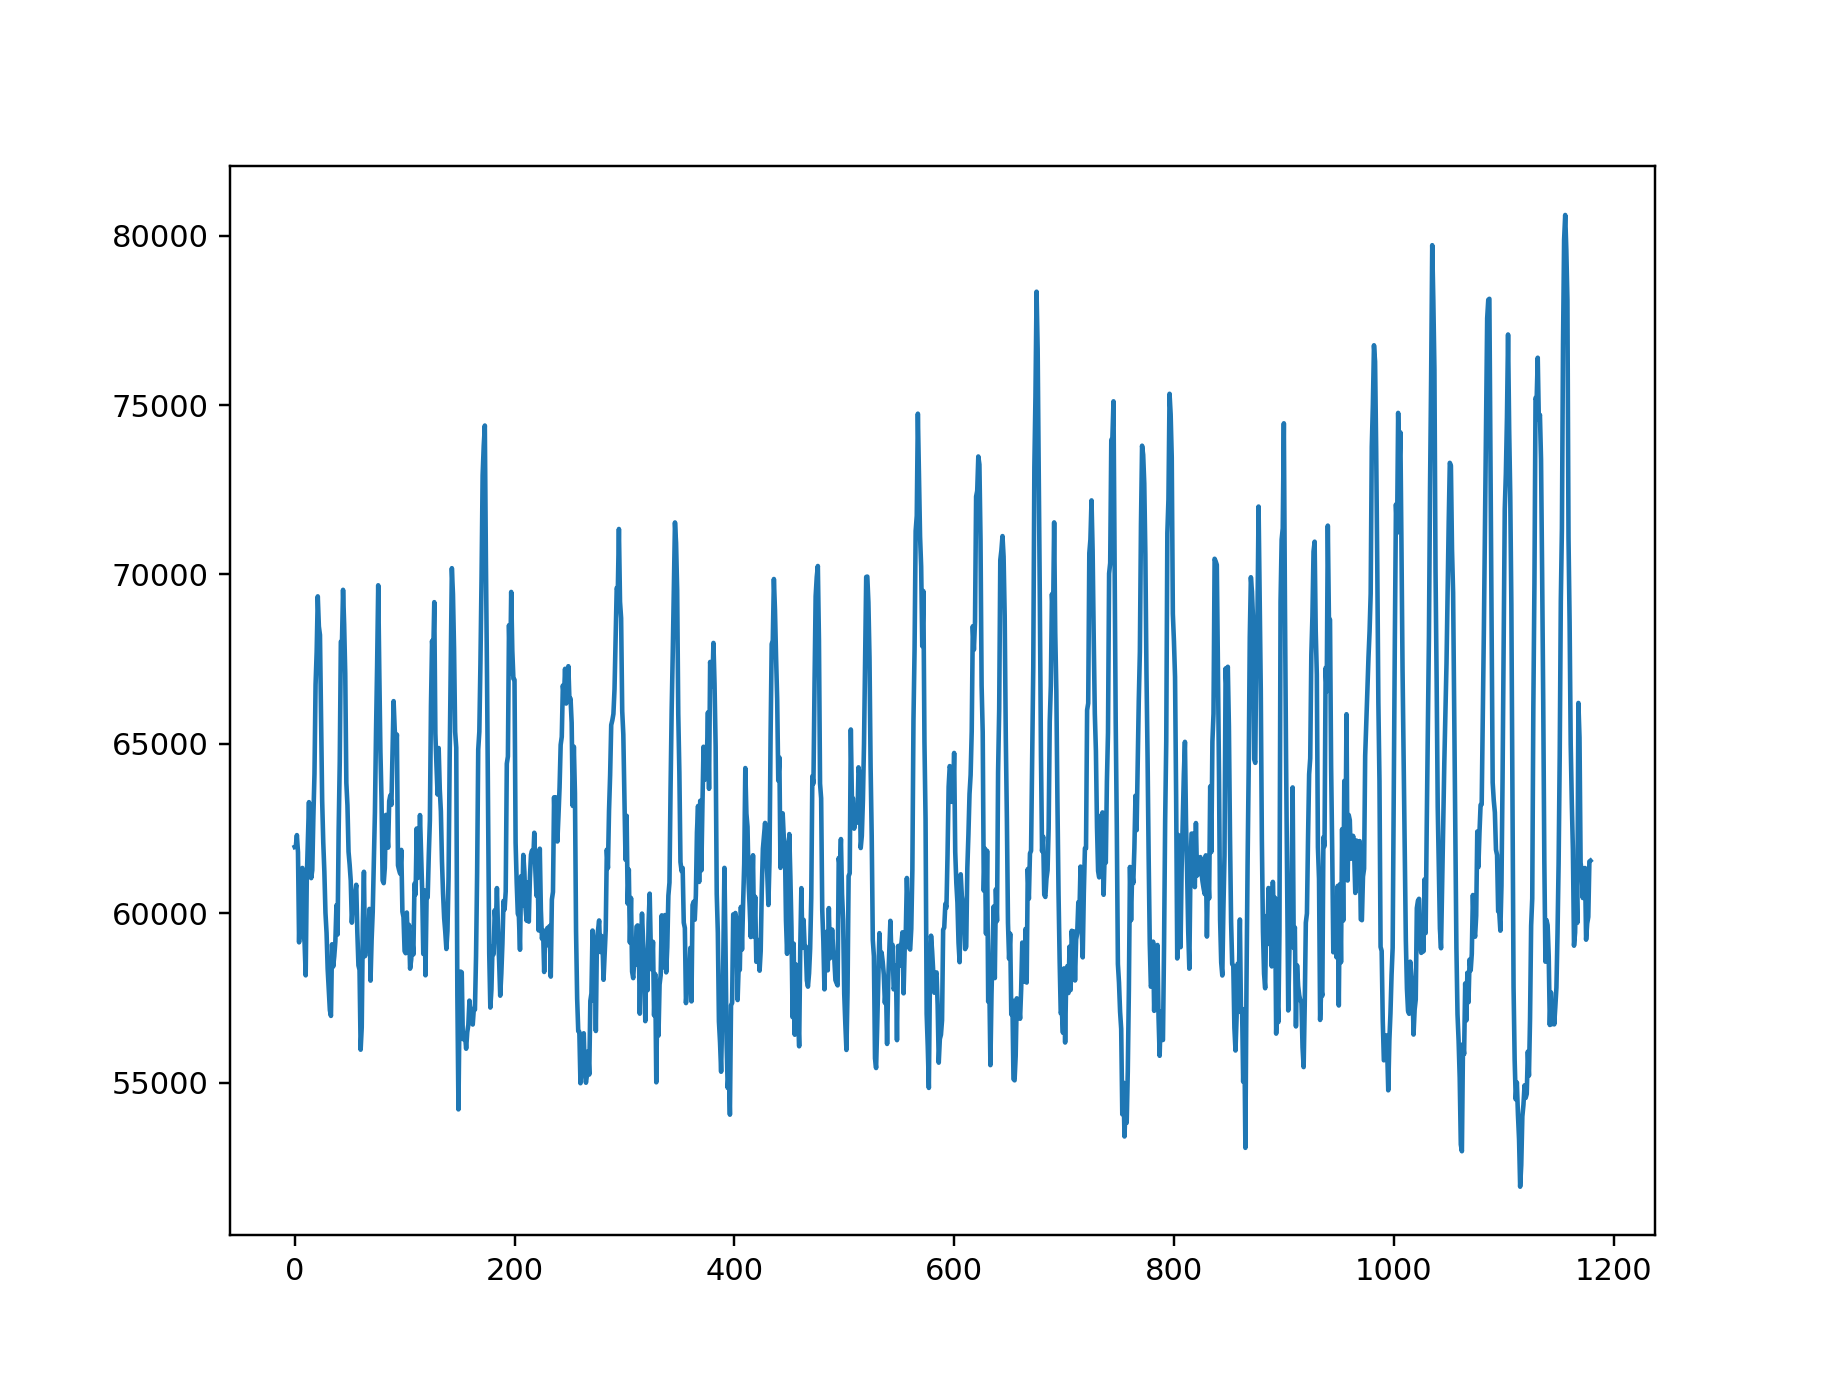

In [31]:
#print(timecourse_brain_nonzerovar.shape)
#a nice voxel for testing should be 185537
fig2=pl.figure()
pl.plot(timecourse_brain_nonzerovar[185537,:])
#pl.plot(sgfilter_predictions(timecourse_brain_nonzerovar[185537,:],
#                                            window_length=121))
#pl.plot(np.load('/Users/marcoaqil/PRFMapping/timecourse_brain_nonzerovar_sub-001.npy')[185537,:])

In [33]:
np.save('/Users/marcoaqil/PRFMapping/timecourse_brain_nonzerovar_sub-001.npy', timecourse_brain_nonzerovar)

In [67]:
#create gaussian grid
grid_nr = 20
max_ecc_size = 16
sizes, eccs, polars = max_ecc_size * np.linspace(0.25,1,grid_nr)**2, \
                    max_ecc_size * np.linspace(0.1,1,grid_nr)**2, \
                        np.linspace(0, 2*np.pi, grid_nr)

gg = Iso2DGaussianGridder(stimulus=prf_stim,
                          filter_predictions=True,
                          window_length=121,
                          cond_lengths=[220,380,220,140,220])

In [68]:
%%time
gf = Iso2DGaussianFitter(data=timecourse_brain_nonzerovar, gridder=gg, n_jobs=10)

gf.grid_fit(ecc_grid=eccs,
                 polar_grid=polars,
                 size_grid=sizes)


  2%|▏         | 147/8000 [10:08<9:38:19,  4.42s/it]


  4%|▎         | 293/8000 [20:09<8:39:08,  4.04s/it]


  5%|▌         | 439/8000 [29:59<8:30:17,  4.05s/it]


  7%|▋         | 585/8000 [39:47<8:18:13,  4.03s/it]


  9%|▉         | 731/8000 [49:34<8:08:47,  4.03s/it]


 11%|█         | 877/8000 [59:22<7:58:49,  4.03s/it]


 13%|█▎        | 1018/8000 [1:08:51<7:47:48,  4.02s/it]


 14%|█▍        | 1156/8000 [1:18:07<7:40:12,  4.03s/it]


 16%|█▌        | 1294/8000 [1:27:24<7:31:29,  4.04s/it]


 18%|█▊        | 1432/8000 [1:36:43<7:23:51,  4.05s/it]


 20%|█▉        | 1570/8000 [1:46:01<7:13:50,  4.05s/it]


 21%|██▏       | 1708/8000 [1:55:19<7:03:08,  4.03s/it]


 23%|██▎       | 1846/8000 [2:04:38<6:54:23,  4.04s/it]


 25%|██▍       | 1984/8000 [2:13:56<6:44:51,  4.04s/it]


 27%|██▋       | 2122/8000 [2:23:15<6:36:58,  4.05s/it]


 28%|██▊       | 2260/8000 [2:32:33<6:27:39,  4.05s/it]


 30%|██▉       | 2398/8000 [2:41:53<6:18:46,  4.06s/it]


 32%|███▏      | 2536/8000 [2:51:12<6:08:23,  4.05s/it]


 33%|███▎      | 2674/8000 [3:00:31<5:59:41,  4.05s/it]


 35%|███▌      | 2812/8000 [3:09:50<5:49:58,  4.05s/it]


 37%|███▋      | 2950/8000 [3:19:09<5:40:59,  4.05s/it]


 39%|███▊      | 3088/8000 [3:28:28<5:31:44,  4.05s/it]


 40%|████      | 3226/8000 [3:37:45<5:22:40,  4.06s/it]


 42%|████▏     | 3364/8000 [3:47:04<5:12:50,  4.05s/it]


 44%|████▍     | 3502/8000 [3:56:24<5:01:20,  4.02s/it]


 46%|████▌     | 3640/8000 [4:05:43<4:54:33,  4.05s/it]


 47%|████▋     | 3778/8000 [4:15:03<4:45:19,  4.05s/it]


 49%|████▉     | 3916/8000 [4:24:22<4:36:05,  4.06s/it]


 51%|█████     | 4054/8000 [4:33:42<4:27:31,  4.07s/it]


 52%|█████▏    | 4192/8000 [4:43:02<4:17:04,  4.05s/it]


 54%|█████▍    | 4330/8000 [4:52:22<4:08:04,  4.06s/it]


 56%|█████▌    | 4468/8000 [5:01:42<3:58:57,  4.06s/it]


 58%|█████▊    | 4606/8000 [5:11:00<3:47:53,  4.03s/it]


 59%|█████▉    | 4744/8000 [5:20:17<3:39:01,  4.04s/it]


 61%|██████    | 4882/8000 [5:29:34<3:30:02,  4.04s/it]


 63%|██████▎   | 5020/8000 [5:38:51<3:20:41,  4.04s/it]


 64%|██████▍   | 5158/8000 [5:48:09<3:10:50,  4.03s/it]


 66%|██████▌   | 5296/8000 [5:57:27<3:01:47,  4.03s/it]


 68%|██████▊   | 5434/8000 [6:06:45<2:53:09,  4.05s/it]


 70%|██████▉   | 5572/8000 [6:16:03<2:43:55,  4.05s/it]


 71%|███████▏  | 5710/8000 [6:25:22<2:34:31,  4.05s/it]


 73%|███████▎  | 5848/8000 [6:34:41<2:25:20,  4.05s/it]


 75%|███████▍  | 5986/8000 [6:44:00<2:16:16,  4.06s/it]


 77%|███████▋  | 6124/8000 [6:53:19<2:07:10,  4.07s/it]


 78%|███████▊  | 6262/8000 [7:02:39<1:57:46,  4.07s/it]


 80%|████████  | 6400/8000 [7:11:58<1:47:51,  4.04s/it]


 82%|████████▏ | 6538/8000 [7:21:18<1:38:52,  4.06s/it]


 83%|████████▎ | 6676/8000 [7:30:38<1:29:13,  4.04s/it]


 85%|████████▌ | 6814/8000 [7:39:58<1:20:10,  4.06s/it]


 87%|████████▋ | 6952/8000 [7:49:18<1:11:00,  4.07s/it]


 89%|████████▊ | 7090/8000 [7:58:37<1:01:33,  4.06s/it]


 90%|█████████ | 7232/8000 [8:08:14<51:58,  4.06s/it]


 92%|█████████▏| 7375/8000 [8:17:54<42:11,  4.05s/it]


 94%|█████████▍| 7518/8000 [8:27:26<32:38,  4.06s/it]


 96%|█████████▌| 7661/8000 [8:37:05<22:46,  4.03s/it]


 98%|█████████▊| 7804/8000 [8:46:44<13:16,  4.06s/it]


 99%|█████████▉| 7947/8000 [8:56:23<03:35,  4.06s/it]


100%|██████████| 8000/8000 [8:59:58<00:00,  4.04s/it]

CPU times: user 1d 31s, sys: 3h 3min 22s, total: 1d 3h 3min 54s
Wall time: 9h 3s


In [85]:
%%time
#refine Gaussian fits
gf.iterative_fit(rsq_threshold=0.1, verbose=True)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  9.7min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 19.1min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 29.8min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed: 43.6min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 62.1min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed: 80.5min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 106.0min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 137.4min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 165.6min


CPU times: user 3min 39s, sys: 11.7 s, total: 3min 50s
Wall time: 3h 29min 2s


[Parallel(n_jobs=10)]: Done 5984 out of 5984 | elapsed: 209.0min finished


1716


<IPython.core.display.Javascript object>


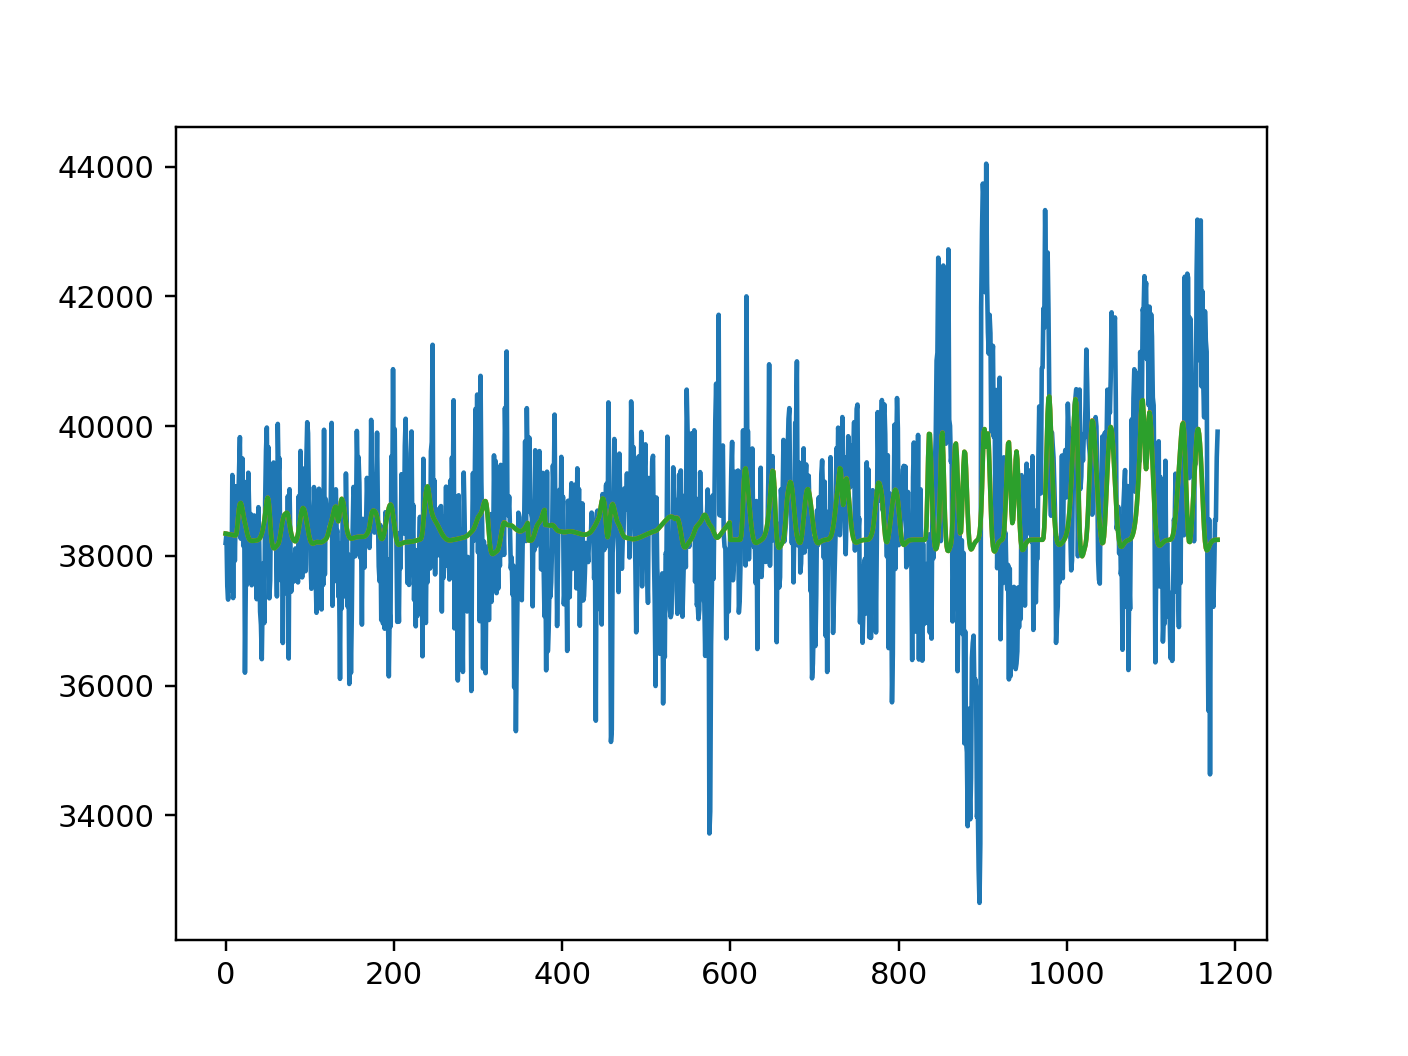

0.10422989882000067
0.10430338012946694


In [78]:
#print(np.min(gf.gridsearch_params[gf.rsq_mask,-1]))
#print(np.min(gf.iterative_search_params[gf.rsq_mask,-1]))
print(np.argmax(gf.gridsearch_params[np.where((gf.gridsearch_params[gf.rsq_mask,-1]<gf.iterative_search_params[gf.rsq_mask,-1])),-1]))
#combined_params = np.copy(gf.iterative_search_params)
#combined_params[np.where(gf.gridsearch_params[gf.rsq_mask,-1]>gf.iterative_search_params[gf.rsq_mask,-1])] = 
fig=pl.figure()

voxel_nr = 1716

print(gf.gridsearch_params[voxel_nr,-1])
print(gf.iterative_search_params[voxel_nr,-1])
#print(gf_norm.gridsearch_params[voxel_nr,-1])

pl.plot(np.load('/Users/marcoaqil/PRFMapping/timecourse_brain_nonzerovar_sub-001.npy')[voxel_nr,:])
pl.plot(gg.return_single_prediction(*list(gf.gridsearch_params[voxel_nr,:-1])))
pl.plot(gg.return_single_prediction(*list(gf.iterative_search_params[voxel_nr,:-1])))
#pl.plot(gg_norm.return_single_prediction(*list(gf_norm.iterative_search_params[voxel_nr,:-1])))

<IPython.core.display.Javascript object>


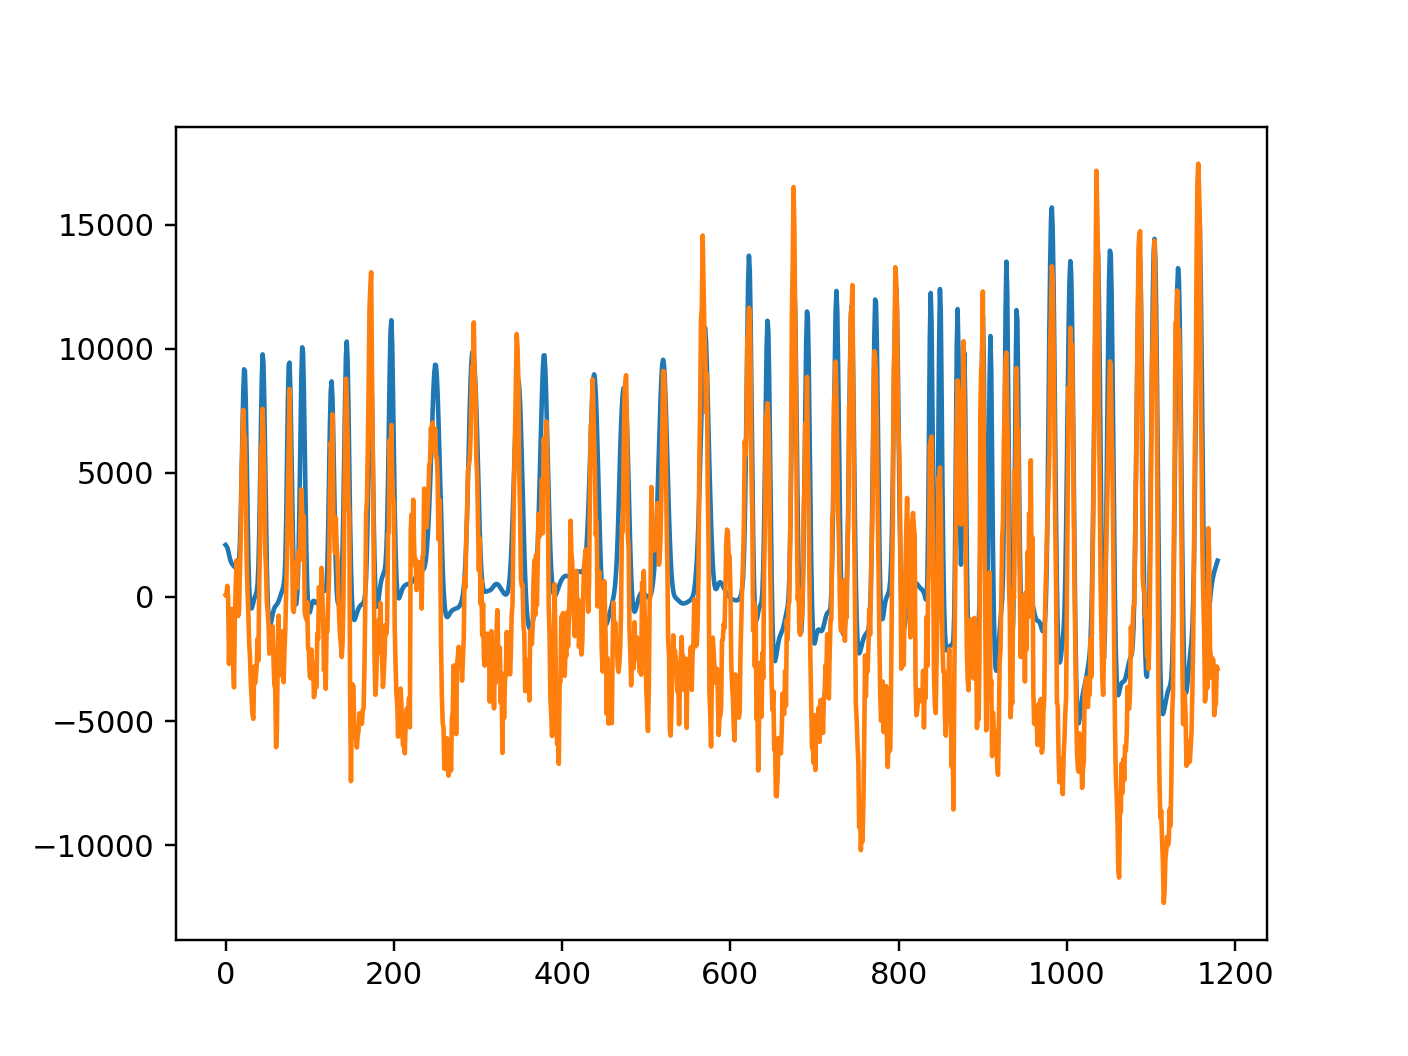

In [217]:
fig = pl.figure()
gg_norm.add_mean=True
pl.plot(gg_norm.return_single_prediction(*list(gf_norm.iterative_search_params[185537,:-1])))
pl.plot(sgfilter_predictions(timecourse_brain_nonzerovar[185537,:],
                                            window_length=121,add_mean=False)
       )

#print(np.argmax(gf.iterative_search_params[:,-1]))

In [ ]:
%%time
#now refit normalization model, starting from results of iterated Gaussian fitting
gg_norm = Norm_Iso2DGaussianGridder(stimulus=prf_stim,
                                   filter_predictions=True,
                                   window_length=121,
                                   cond_lengths=[220,380,220,140,220])
inf=np.inf
eps=1e-16 #to avoid dividing by zero
gf_norm = Norm_Iso2DGaussianFitter(data=timecourse_brain_nonzerovar,
                                   gridder=gg_norm,
                                   n_jobs=10,
                                   bounds=[(-inf,+inf),  #x
                                           (-inf,+inf),  #y
                                           (0,+inf),     #prf size
                                           (-inf,+inf),  #prf amplitude
                                           (0,+inf),     #bold baseline
                                           (0,+inf),     #neural baseline
                                           (0,+inf),     #surround amplitude 
                                           (0,+inf),     #surround size
                                           (eps,+inf)])    #surround baseline    
                                     

#have to add a column since in current code syntax
#gridsearch_params always contains the CSS exponent parameter, even if it is not fit.
#whereas iterative_search_params does not contain it if it is not fit)
starting_params = np.insert(gf.iterative_search_params, -1, 1.0, axis=-1)

gf_norm.iterative_fit(rsq_threshold=0.0, gridsearch_params=starting_params, verbose=True)

current_result=np.copy(gf_norm.iterative_search_params)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.4min


In [132]:
np.inf

inf

In [107]:
#compare rsq between models (ideally should be AIC or BIC)
print(np.mean(gf_norm.iterative_search_params[gf.rsq_mask,-1]))
print(np.mean(gf.iterative_search_params[gf.rsq_mask,-1]))
print(np.mean(gf.gridsearch_params[gf.rsq_mask,-1]))

print(np.where(gf_norm.iterative_search_params[gf.rsq_mask,-1]<0.1))
print(np.where((gf_norm.iterative_search_params[:,-1]<0.1) & (gf_norm.iterative_search_params[:,-1]>0)))
print(gf_norm.iterative_search_params.shape)

0.2748696825191714
0.24268454681897428
0.23882061901344948
(array([ 671, 1090, 2692, 2735, 3973, 4828]),)
(array([ 55102,  68228, 135534, 139351, 176720, 195546]),)
(258326, 10)


In [88]:
np.save('/Users/marcoaqil/PRFMapping/norm_first_iterparams_sub-001.npy', current_result)

In [ ]:
%%time
#if needed, the normalization model iterative fit can be run again 
#(this makes sense only if changing some values in iterative_search minimization for increased precision)
new_starting_params = np.insert(current_result, -1, 1.0, axis=-1)
gf_norm.iterative_fit(rsq_threshold=0.0, gridsearch_params=new_starting_params, verbose=True)
current_result=np.copy(gf_norm.iterative_search_params)

In [114]:
ecc = np.sqrt(gf_norm.iterative_search_params[:,1]**2 + gf_norm.iterative_search_params[:,0]**2)
polar = np.arctan2(gf_norm.iterative_search_params[:,1], gf_norm.iterative_search_params[:,0])


0.7719452321683282


In [113]:
#save results for plotting

attempt = np.zeros((final_mask.shape[0],final_mask.shape[1],final_mask.shape[2],10))
ha = attempt.reshape((-1,10))

combined_mask = np.ravel(np.var(timecourse_full_iso, axis=-1)>0) & np.ravel(final_mask)

ha[combined_mask,2:]=gf_norm.iterative_search_params[:,2:]
ha[combined_mask,0] = ecc
ha[combined_mask,1] = polar

haha = ha.reshape((final_mask.shape[0],final_mask.shape[1],final_mask.shape[2],10))


for i in range(0,10):
    nb.Nifti1Image(haha[:,:,:,i], timecoursefile_ses_1.affine).to_filename('norm{}.nii.gz'.format(i))


In [120]:
haaa= nb.load('/Users/marcoaqil/PRFMapping/PRFMapping-Deriv-noflairtse-manual-hires/fmriprep/sub-001/ses-1/func/sub-001_ses-1_task-1S_run-1_space-fsaverage_hemi-L.func.gii')

In [121]:
data = np.array([h.data for h in haaa.darrays])
data.shape

(385, 163842)

In [118]:
h0.data

array([59769.69 , 58417.887, 57706.723, ..., 37493.02 , 37692.707,
       38230.73 ], dtype=float32)